In [ ]:
import copy
import json
import os
import shutil
import cv2
import time
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import Image
import import_ipynb
from rotate_translate import node
from parent_child_tree import createtree
from multipleoperation import *
from subprocess import run
import open3d as o3d
import time
from pyntcloud import PyntCloud

Below Code generates 2 Contours for a given shape. One 'Outer Contour' and other 'Inner Contour' for a 2 shape .


In [ ]:
print("Please enter the image view file with extension")
s=input()
image=cv2.imread(s)
imgray=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(imgray,127,255,0,cv2.THRESH_BINARY_INV)
contours, hierarchy = cv2.findContours(thresh,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_NONE)
hierarchy,contours = zip(*sorted(zip(hierarchy[0],contours),key = lambda x: cv2.contourArea(x[1]),reverse=True))
print ("no, of contours = " + str(len(contours)-1))
cv2.drawContours(image, contours, 1, (0, 255, 0), 2)
cv2.drawContours(image, contours, 2, (0, 0 , 255), 2)
cv2.imshow('IMAGE', image)
cv2.imshow('Image Gray', imgray)
cv2.waitKey(0)

In [ ]:
print("Please enter the image view file with extension")
s=input()
image=cv2.imread(s)
imgray=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(imgray,127,255,0,cv2.THRESH_BINARY_INV)
contours, hierarchy = cv2.findContours(thresh,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_NONE)
hierarchy,contours = zip(*sorted(zip(hierarchy[0],contours),key = lambda x: cv2.contourArea(x[1]),reverse=True))

Please enter the image view file with extension
front.png


Below Function 'detect()' will determine the shape of a given 2D image on the basis of number of edges in the given Shape . 

Allowed Shapes for a 2d Image are : Triangle , Square , Rectangle , Pentagon , Hexagon , Circle 


In [ ]:
def detect(c):
    perimeter = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * perimeter , True)
    if len(approx) == 3:
        shape = "triangle"
    elif len(approx) == 4:
        (x, y, w, h) = cv2.boundingRect(approx)
        ar = w / float(h)
        if (ar >= 0.999 and ar <= 1.001):
            shape = "square" 
        else:
            shape = "rectangle"
    elif len(approx) == 5:
        shape = "pentagon"
    elif len(approx) == 6:
        shape = "hexagon"
    else:
        shape = "circle"
    return shape

In [ ]:
d=detect(contours[1])
print(d)

rectangle


Below 'Dimensioning()' function stores the image temprory amd gives Image imformation like its 'Shape' and 'Ratio'

In [ ]:
def Dimensioning(userId,view,image):
    os.makedirs('static/temp', exist_ok=True)
    img = cv2.imread(image,cv2.IMREAD_UNCHANGED)
    ratio = 0
    shape = "unidentified"
    try:
        w,h,_=img.shape
        drawSize = int(h/300)
        imgrey = cv2.cvtColor(img.copy(),cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(imgrey,127,255,cv2.THRESH_BINARY_INV)
        contours, hierarchy = cv2.findContours(thresh,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
        hierarchy,contours = zip(*sorted(zip(hierarchy[0],contours),key = lambda x: cv2.contourArea(x[1]),reverse=True))
        for i,c in enumerate(contours):
            if(hierarchy[i][3] != -1  or (hierarchy[i][3] == -1 and hierarchy[i][2] == -1) ):
                M = cv2.moments(c)
                if(M["m00"] !=0):
                    cX = int(M["m10"] / M["m00"])
                    cY = int(M["m01"] / M["m00"])
                    rect = cv2.minAreaRect(c)
                    box = cv2.boxPoints(rect)
                    box = np.int0(box)
                    x,y,w,h = cv2.boundingRect(c)
                    shape, cylinder_type = detect(c)              
                    if(shape == "unidentified"):
                        continue
                    if(shape=="triangle" or shape=="pentagon" or shape=="hexagon"):
                        img = cv2.drawContours(img, [box], 0, (0,0, 255), drawSize)
                    if(shape=="circle"):
                        img = cv2.rectangle(img,(x,y),(x+w,y+h),(0, 0, 255),drawSize)
                        cv2.line(img, (x,y), (x+w,y), (0,255, 0), 2)
                        ratio = 1/w
                    else:
                        cv2.line(img, tuple(box[0]), tuple(box[1]), (0,255, 0), 2)
                        ratio = 1.0/rect[1][1]
                    break
        folder = 'static/temp/' + userId
        os.makedirs(folder, exist_ok=True)
        try:
            os.remove(folder + '/' + view + '.jpg')
        except: pass
        path_file = (folder + '/' + view + '.jpg')
        small = cv2.resize(img, (0,0), fx=0.5, fy=0.5) 
        cv2.imwrite(path_file,small)
        ratio = str(ratio)
        data={'image': path_file,'shape': shape,'ratio': ratio}
        display(Image(filename = path_file))
        return data
    except:
        print(view + "image not found")

importing Jupyter notebook from shape.ipynb
importing Jupyter notebook from tree.ipynb
importing Jupyter notebook from operation.ipynb


In [ ]:
def Convert(userId, front_image, side_image, top_image, fratio, sratio, tratio): 
    start = time.time() 
    os.makedirs('static/'+userId, exist_ok=True)
    img_front = cv2.imread(front_image,cv2.IMREAD_UNCHANGED)
    img_side = cv2.imread(side_image,cv2.IMREAD_UNCHANGED)
    img_top = cv2.imread(top_image,cv2.IMREAD_UNCHANGED)
    fratio = float(fratio)
    sratio = float(sratio)
    tratio = float(tratio)
    filePath = "static/temp/"+userId
    try:
        shutil.rmtree(filePath)
    except OSError as e:
        print ("Error: %s - %s." % (e.filename, e.strerror))
    primitive = []
    object_front = valid_contours(img_front,"front",fratio)
    re_arrange(object_front,"front")
    object_side = valid_contours(img_side,"side",sratio)
    re_arrange(object_side,"side")
    object_top = valid_contours(img_top,"top",tratio)
    re_arrange(object_top,"top")
    minApprox = 0.05
    primitive = combining(object_front,object_side,object_top,minApprox)
    final = []
    for set in primitive:
        for shape in set:
            final.append(shape[0])
    try:
        os.remove('static/' + userId + "/" + userId + '.scad')
    except: pass
    path_file = ('static/' + userId + "/" + userId + '.scad')
    if(len(final) == 0):
        path_file = 'static/error.txt'
        f = open(path_file, "w")
        f.write("Cannot determine the 3d geometry, check your files again!")
        f.close()
    createtree(final,path_file)
    end = time.time() 
    print("Total time taken to convert:",end-start)
    return path_file

In [ ]:
userId="1"
front_image = "TestBench/"+userId+"/front.jpg"
side_image = "TestBench/"+userId+"/side.jpg"
top_image = "TestBench/"+userId+"/top.jpg"
front_image

'TestBench/1/front.jpg'

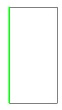

{'image': 'static/temp/1/front.jpg',
 'shape': 'rectangle',
 'ratio': '0.0052083341611757535'}

In [ ]:
d1 = Dimensioning(userId,"front",front_image)
d1

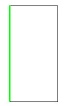

{'image': 'static/temp/1/side.jpg',
 'shape': 'rectangle',
 'ratio': '0.0052083341611757535'}

In [ ]:
d2 = Dimensioning(userId,"side",side_image)
d2

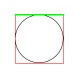

{'image': 'static/temp/1/top.jpg',
 'shape': 'circle',
 'ratio': '0.010309278350515464'}

In [ ]:
d3 = Dimensioning(userId,"top",top_image)
d3

In [ ]:
fratio = float(d1["ratio"]) * 2 
sratio = float(d2["ratio"]) * 2
tratio = float(d3["ratio"]) * 2

Convert Function joins the multiple 2D images with their respective Ratio to insert them in a tree to form a 3D model from it .
If the given shape consist of more than one shape (complex object in Image object) Than we will sub divide it to individual shapes and store them in tree as Parent and Child . 

In [ ]:
Convert(userId,front_image, side_image, top_image,fratio, sratio, tratio)

Subtree: 1
Total time taken to convert: 0.0239865779876709


'static/1/1.scad'

Point Cloud Representation of the generated Scad File 


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
please wait generating 3D view...
stl file generated at static/1/1.stl
pcd file generated at static/1/1.pcd


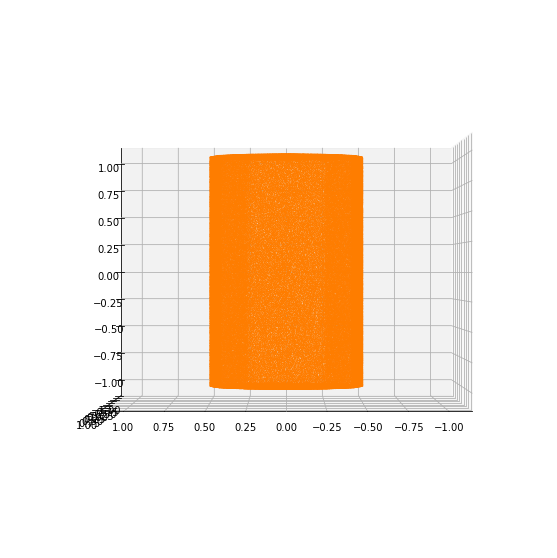

Total time taken to convert from stl to point cloud: 160.79359769821167


In [ ]:
print("please wait generating 3D view...") 
start = time.time() 
scad_filename = "static/" + userId + '/' + userId + ".1.scad"
stl_filename = "static/" + userId + '/' + userId + ".stl"
pcd_filename = "static/" + userId + '/' + userId + ".pcd"
if(os.path.isfile(scad_filename)):
    run("openscad.exe -o " + stl_filename + " " + scad_filename)
    if(os.path.isfile(stl_filename)):
        print("stl file generated at " + stl_filename)
        mesh = o3d.io.read_triangle_mesh(stl_filename)
        pointcloud = mesh.sample_points_poisson_disk(100000)
        o3d.io.write_point_cloud(pcd_filename, pointcloud)
        model = PyntCloud.from_file(pcd_filename)
        print("pcd file generated at " + pcd_filename)
        model.plot() 
        end = time.time() 
        print("Total time taken to convert from stl to point cloud:",end-start)
    else:
        print("file not found")
else:
    print("scad file not found")